In [6]:
import numpy as np
from scipy.stats import truncnorm


class Layer(object):

    def __init__(self, dim_input, dim_output, std=1., bias=0.):
        self.w = truncnorm(a=-2 * std, b=2 * std, scale=std).rvs((dim_input, dim_output))
        self.b = np.ones(dim_output) * bias

    def __call__(self, X):
        self.input = X
        return self.forward_propagation(X)

    def back_propagation(self, delta, learning_rate):
        # derivative with respect to activation
        delta = delta * self.activation_derivative()

        w = np.copy(self.w)
        self.w -= learning_rate * self.input.T.dot(delta)
        self.b -= learning_rate * np.sum(delta, axis=0)

        # derivative with respect to input
        return delta.dot(w.T)


class LinearLayer(Layer):

    def forward_propagation(self, X):
        return X.dot(self.w) + self.b

    def activation_derivative(self):
        return 1


class SigmoidLayer(Layer):

    def forward_propagation(self, X):
        activation = X.dot(self.w) + self.b
        self.output = 1 / (1 + np.exp(-activation))
        return self.output

    def activation_derivative(self):
        return self.output * (1 - self.output)


class TanhLayer(Layer):

    def forward_propagation(self, X):
        activation = X.dot(self.w) + self.b
        self.output = np.tanh(activation)
        return self.output

    def activation_derivative(self):
        return 1 - self.output ** 2


class ReLULayer(Layer):

    def forward_propagation(self, X):
        activation = X.dot(self.w) + self.b
        self.output = activation.clip(min=0)
        return self.output

    def activation_derivative(self):
        return (self.output > 0).astype(np.float)


class SigmoidCrossEntropy(object):

    def activate(self, logits):
        return 1 / (1 + np.exp(-logits))

    def __call__(self, logits, targets):
        probs = self.activate(logits)
        p = np.clip(probs, 1e-10, 1 - 1e-10)
        return np.sum(-targets * np.log(p) - (1 - targets) * np.log(1 - p))

    def delta(self, logits, targets):
        probs = self.activate(logits)
        return probs - targets


class SoftmaxCrossEntropy(object):

    def activate(self, logits):
        a = np.exp(logits - np.max(logits, 1, keepdims=True))
        a /= np.sum(a, 1, keepdims=True)
        return a

    def __call__(self, logits, targets):
        probs = self.activate(logits)
        p = probs.clip(min=1e-10)
        return - np.sum(targets * np.log(p))

    def delta(self, logits, targets):
        probs = self.activate(logits)
        return probs - targets


class SumSquaresError(object):

    def activate(self, X):
        return X

    def __call__(self, X, targets):
        return 0.5 * np.sum((X - targets) ** 2)

    def delta(self, X, targets):
        return X - targets

class NeuralNetwork(object):

    def __init__(self, layers, cost_function):
        self.layers = layers
        self.cost_function = cost_function

    def __call__(self, X):
        for layer in self.layers:
            X = layer(X)
        return self.cost_function.activate(X)

    def fit(self, X, t, learning_rate):
        for layer in self.layers:
            X = layer(X)

        delta = self.cost_function.delta(X, t)
        for layer in reversed(self.layers):
            delta = layer.back_propagation(delta, learning_rate)

    def cost(self, X, t):
        for layer in self.layers:
            X = layer(X)
        return self.cost_function(X, t)

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def create_toy_dataset():
    x = np.random.uniform(-1., 1., size=(1000, 2))
    labels = (np.prod(x, axis=1) > 0).astype(np.float)
    return x, labels.reshape(-1, 1)

step      0, cost 731.427938
step  10000, cost 42.669676
step  20000, cost 41.472233
step  30000, cost 71.385538
step  40000, cost 30.650396
step  50000, cost 30.725621
step  60000, cost 29.397976
step  70000, cost 65.936572
step  80000, cost 28.512418
step  90000, cost 30.346007


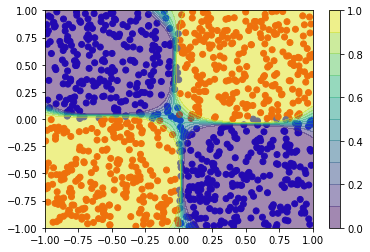

In [8]:
    x, labels = create_toy_dataset()
    colors = ["blue", "red"]
    plt.scatter(x[:, 0], x[:, 1], c=[colors[int(label)] for label in labels])

    layers = [TanhLayer(2, 4), LinearLayer(4, 1)]
    cost_function = SigmoidCrossEntropy()
    nn = NeuralNetwork(layers, cost_function)
    #nn._gradient_check()
    for i in range(100000):
        if i % 10000 == 0:
            print("step %6d, cost %f" % (i, nn.cost(x, labels)))
        nn.fit(x, labels, learning_rate=0.001)

    X_test, Y_test = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
    x_test = np.array([X_test, Y_test]).transpose(1, 2, 0).reshape(-1, 2)
    probs = nn(x_test)
    Probs = probs.reshape(100, 100)
    levels = np.linspace(0, 1, 11)
    plt.contourf(X_test, Y_test, Probs, levels, alpha=0.5)
    plt.colorbar()
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.show()